# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (270/270), done.
remote: Total 36449 (delta 160), reused 53 (delta 53), pack-reused 36126 (from 4)
Receiving objects: 100% (36449/36449), 22.34 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (26238/26238), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical name, but actually scaled down below

# YOLO11n backbone (scaled)
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [16, 3, 2]]              # 0
  - [-1, 1, Conv, [32, 3, 2]]              # 1
  - [-1, 1, C3k2, [64, False, 0.25]]       # 2
  - [-1, 1, Conv, [64, 3, 2]]              # 3
  - [-1, 1, C3k2, [128, False, 0.25]]      # 4  ← P3
  - [4, 1, CBAM, [128]]                    # 5

  - [-1, 1, Conv, [128, 3, 2]]             # 6
  - [-1, 1, C3k2, [128, True]]             # 7  ← P4
  - [7, 1, CBAM, [128]]                    # 8

  - [-1, 1, Conv, [256, 3, 2]]             # 9
  - [-1, 1, C3k2, [256, True]]             # 10
  - [-1, 1, SPPF, [256, 5]]                # 11
  - [-1, 1, C2PSA, [256]]                  # 12 ← P5
  - [12, 1, CBAM, [256]]                   # 13

head:
  - [13, 1, nn.Upsample, [None, 2, "nearest"]]           # 14
  - [[-1, 8], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 16

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 17
  - [[-1, 5], 1, Concat, [1]]
  - [-1, 1, C3k2, [64, False]]                           # 19

  - [-1, 1, Conv, [64, 3, 2]]                            # 20
  - [[-1, 16], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 22

  - [-1, 1, Conv, [128, 3, 2]]                           # 23
  - [[-1, 13], 1, Concat, [1]]
  - [-1, 1, C3k2, [256, True]]                           # 25

  - [[19, 22, 25], 1, Detect, [nc]]                      # 26
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                   4  1     16610  ultralytics.nn.modules.conv.CBAM             [128]                         
  6                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]          

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:04<00:00, 124.25it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 129.88it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 94 weight(decay=0.0005), 90 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300       2.6G      3.967      87.88      3.104         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.78G      4.339      50.93      3.295         45        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.79G      3.926      17.68      2.168         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]


                   all        200       1017          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.79G      3.856      4.796      1.749         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1017     0.0772    0.00688    0.00232   0.000656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.79G      3.669      3.752      1.475         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


                   all        200       1017      0.135     0.0767     0.0323    0.00739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.79G       3.55       3.28      1.366         17        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


                   all        200       1017      0.112      0.111     0.0288    0.00566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.79G      3.477      3.036      1.354         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


                   all        200       1017      0.173      0.153     0.0538     0.0107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.79G      3.418      2.855      1.281          7        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200       1017      0.204      0.188     0.0834     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.79G      3.288        2.5      1.252         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


                   all        200       1017      0.234      0.199      0.102     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.79G      3.361      2.476      1.227         42        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        200       1017      0.258      0.189      0.096      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.79G      3.296      2.335      1.158         68        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200       1017      0.269      0.221      0.127     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.79G      3.201      2.227       1.21         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.289      0.208      0.116     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.79G      3.142      2.173      1.183         15        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200       1017      0.323      0.248      0.138     0.0316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.79G      3.107      2.082      1.179         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        200       1017      0.346      0.264      0.162     0.0362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.79G      3.107      2.026       1.15         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]


                   all        200       1017      0.368      0.308      0.197     0.0428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.79G       3.04       1.98      1.213         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.295      0.211      0.118     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.79G      3.033      1.884      1.157         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        200       1017       0.36      0.284      0.195     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.79G      3.004      1.884      1.187         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1017      0.428      0.295      0.205     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.79G       2.95      1.769      1.138         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        200       1017      0.402      0.295      0.202      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.79G      2.966      1.796      1.129         21        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]

                   all        200       1017      0.405      0.287      0.215     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.79G      2.946      1.703      1.153         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.364      0.257      0.171     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.79G      3.071       1.83      1.186         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


                   all        200       1017      0.395      0.285      0.199     0.0479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.79G      2.968      1.796      1.166         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017       0.35      0.292      0.178     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.79G      2.886      1.664      1.121         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.419      0.332      0.255      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.79G      2.833      1.644      1.147         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


                   all        200       1017      0.409      0.278      0.212     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.79G      2.854      1.636      1.136         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.431       0.33      0.238     0.0606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.79G      2.869      1.606      1.095         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.456      0.326      0.245     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.79G       2.83      1.614      1.103         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.455      0.347      0.274     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.79G      2.802      1.575      1.134         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        200       1017      0.459       0.32      0.252     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.79G      2.781       1.52      1.119         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.514       0.34       0.29     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.79G      2.771      1.531      1.108         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.482      0.351      0.294     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.79G      2.792      1.447      1.088         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200       1017      0.503       0.36      0.298     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.79G      2.733      1.509      1.083         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.476       0.34      0.302     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.79G      2.704      1.444      1.108         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.505      0.376      0.332     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.79G      2.738       1.46       1.06         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200       1017      0.484      0.336      0.284      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.79G      2.673      1.427      1.126         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200       1017      0.506       0.37      0.317     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.79G      2.758      1.452       1.08         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        200       1017      0.483      0.358      0.301      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.79G      2.675      1.421      1.076         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017      0.508       0.37      0.336     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.79G      2.672      1.375      1.078         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


                   all        200       1017      0.474       0.36      0.307     0.0832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.79G      2.649      1.427      1.107         18        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.424      0.346      0.263     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.79G      2.666      1.413      1.072         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017        0.5      0.358       0.32     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.79G      2.647      1.442      1.089         23        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


                   all        200       1017      0.453      0.375      0.322     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.79G      2.652      1.351      1.053         36        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.454      0.397      0.325      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.79G      2.617      1.365      1.086         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.488      0.341       0.31     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.79G      2.651      1.371      1.084         54        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.457      0.357      0.291     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.79G      2.584      1.323      1.093         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        200       1017      0.443      0.399      0.329     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.79G      2.672      1.376      1.085         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200       1017      0.531      0.381      0.342      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.79G      2.547      1.352      1.105         14        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


                   all        200       1017       0.53      0.395      0.371       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.79G       2.64      1.384      1.058         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200       1017      0.547      0.391      0.361      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.79G      2.662      1.357      1.052         12        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        200       1017      0.509      0.376      0.348     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.79G      2.682      1.364      1.115         24        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200       1017      0.556      0.393      0.373      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.79G       2.53      1.299      1.086         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


                   all        200       1017      0.545      0.392       0.36     0.0995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.79G      2.596      1.346      1.075         62        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        200       1017      0.552      0.409      0.379      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.79G      2.525      1.304      1.095         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.547      0.397      0.369       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.79G      2.568      1.307      1.073         39        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.511      0.391      0.337     0.0868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.79G      2.535      1.263      1.053         12        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.552      0.382      0.373      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.79G        2.5      1.279      1.075         52        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        200       1017      0.571      0.378      0.378      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.79G      2.598      1.314      1.064         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


                   all        200       1017      0.546      0.403      0.383      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.79G      2.504      1.291      1.058         34        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.509      0.423      0.366      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.79G      2.551      1.287      1.051         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017       0.58      0.422      0.403      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.79G       2.54      1.264      1.053         16        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.517      0.382      0.361      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.79G      2.503      1.255      1.068         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200       1017      0.548      0.407      0.387      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.79G      2.472      1.307      1.038         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


                   all        200       1017      0.556      0.407      0.389      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.79G      2.479      1.262       1.07         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200       1017      0.466      0.363      0.317     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.79G      2.508      1.303      1.067         37        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.552      0.392      0.367      0.099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.79G      2.481      1.274       1.08         13        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200       1017      0.523      0.368      0.326     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.79G      2.557      1.277      1.062         62        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.546      0.415      0.391      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.79G      2.483      1.249       1.05         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        200       1017      0.544      0.356      0.348      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.79G      2.488      1.224       1.03         50        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200       1017      0.538      0.418      0.365      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.79G      2.457       1.25      1.066         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.568      0.402      0.396      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.79G      2.483      1.263      1.053         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


                   all        200       1017      0.556      0.403       0.39      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.79G      2.442      1.223      1.044         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.587        0.4      0.416      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.79G      2.489      1.266      1.065         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017      0.528      0.431      0.393      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.79G      2.439      1.206       1.04         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017      0.549      0.387      0.381      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.79G        2.4      1.206      1.028         39        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.527      0.419      0.375      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.79G      2.414      1.213      1.028         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.532       0.41      0.387      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.79G      2.401      1.204      1.038         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        200       1017      0.565      0.407       0.41      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.79G      2.385      1.228      1.092         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.573      0.421      0.407       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.79G      2.397      1.197      1.057         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        200       1017      0.579      0.417      0.397      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.79G      2.492      1.233       1.04         44        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.561       0.41      0.412      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.79G      2.408      1.207      1.042         40        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.486      0.382      0.361      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.79G      2.467       1.23       1.06         23        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.569      0.421      0.412      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.79G      2.396       1.19      1.037         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.533      0.409        0.4      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.79G      2.408      1.179      1.034         46        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.544      0.423      0.382      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      2.79G       2.45      1.217      1.056         45        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.579      0.426      0.412      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.79G      2.418      1.244      1.072         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        200       1017      0.565      0.407      0.414      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.79G      2.401      1.212      1.044         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.592      0.426       0.43      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.79G      2.397      1.196      1.005         38        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


                   all        200       1017      0.585      0.428       0.42      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.79G      2.334      1.167      1.031         65        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017       0.59      0.405      0.407      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.79G      2.358      1.182      1.049         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.641      0.405      0.429      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.79G      2.418      1.198      1.025         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.565      0.438      0.426      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.79G      2.392       1.16       1.03         53        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


                   all        200       1017      0.571      0.383      0.391      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.79G      2.403      1.179      1.029         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        200       1017      0.558        0.4      0.387      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.79G      2.328      1.146      1.027         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.566      0.428      0.422      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.79G      2.406      1.196      1.043         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.574      0.405      0.379      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.79G      2.413      1.209       1.07         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017      0.625       0.43       0.44      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.79G      2.359      1.171      1.038         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200       1017      0.589      0.399      0.404      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.79G      2.379      1.141      1.013         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.544      0.407      0.396      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.79G       2.31      1.142      1.027         43        640: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        200       1017      0.578      0.434      0.423      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.79G      2.432      1.175      1.039         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

                   all        200       1017      0.603      0.428      0.426      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.79G      2.402      1.185      1.029         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200       1017      0.594      0.432      0.433      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.79G      2.369      1.161      1.023         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200       1017      0.607      0.443      0.442      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.79G      2.346      1.133      1.029         43        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200       1017       0.55      0.431      0.416      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.79G      2.337      1.144      1.028         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


                   all        200       1017      0.528       0.43      0.411      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.79G      2.332      1.168      1.021         23        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        200       1017       0.57      0.449       0.43      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.79G       2.33      1.146      1.034         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017       0.53      0.408      0.382      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.79G      2.303      1.133       1.02         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200       1017      0.597       0.44       0.44      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.79G      2.393      1.157      1.021         18        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        200       1017      0.584      0.403      0.405      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.79G      2.305      1.129      1.016         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.563      0.393        0.4      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.79G      2.313       1.13     0.9961         40        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200       1017      0.617      0.443      0.429      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.79G      2.391      1.186      1.017         17        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200       1017      0.618      0.436      0.456      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.79G       2.39      1.176       1.03         38        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200       1017      0.613      0.432      0.446      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.79G      2.312      1.144      1.031         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017      0.578      0.413      0.406       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.79G      2.339      1.162       1.01         37        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.591      0.414      0.423      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.79G      2.295      1.129       1.03         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        200       1017      0.614      0.441      0.452      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.79G      2.304      1.102      1.009         33        640: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        200       1017       0.62      0.442      0.448      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.79G      2.335      1.123     0.9953         37        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        200       1017      0.585      0.438      0.436      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.79G      2.269      1.084     0.9889         57        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        200       1017      0.608      0.456      0.446      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.79G      2.274      1.117     0.9947         29        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


                   all        200       1017      0.614      0.432      0.446      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.79G      2.335      1.154      1.032         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.606      0.419      0.421      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.79G      2.249      1.113      1.012         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200       1017      0.613      0.424      0.444      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      2.79G      2.201      1.088      1.025         42        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200       1017      0.542      0.421       0.41      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.79G      2.275      1.111      1.001         11        640: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200       1017      0.585      0.431      0.421      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      2.79G      2.253      1.097     0.9928         26        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017      0.596      0.418      0.426       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.79G      2.342      1.115     0.9967         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        200       1017      0.585      0.457       0.45       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.79G      2.274      1.075      1.023         43        640: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        200       1017      0.593       0.44      0.438      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.79G      2.268      1.104      1.017         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.573      0.433      0.432      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      2.79G      2.284      1.108      1.018         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


                   all        200       1017      0.621      0.454      0.452      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      2.79G       2.29      1.075      1.003         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200       1017      0.624      0.431      0.442      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.79G      2.262      1.111      1.034         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200       1017      0.597      0.434      0.428       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.79G      2.258      1.076      1.006         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.588      0.457       0.45      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      2.79G      2.273      1.076     0.9951         44        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        200       1017      0.618      0.464       0.46      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.79G      2.255       1.12      1.035         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        200       1017      0.589      0.418      0.411      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.79G      2.254       1.09      1.005         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        200       1017      0.599       0.44      0.448      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.79G      2.264      1.148      1.019         20        640: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        200       1017      0.589       0.44      0.443       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.79G      2.193      1.071     0.9829         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        200       1017      0.576      0.451      0.443      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      2.79G       2.26        1.1      1.003         28        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.625      0.466      0.465      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.79G      2.282      1.082      1.016         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200       1017      0.636      0.468      0.463      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.79G      2.312      1.104     0.9987         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017      0.625      0.441      0.446      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.79G       2.25      1.097      1.022         53        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


                   all        200       1017      0.601      0.472      0.461       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      2.79G       2.28      1.087     0.9886         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        200       1017      0.591      0.469      0.458      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.79G      2.193      1.019     0.9975         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.608      0.449      0.442      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.79G      2.169      1.044      1.006         52        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.592      0.448      0.448      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.79G      2.205      1.076      1.033         44        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200       1017      0.601      0.474      0.469      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.79G       2.21      1.054      1.011         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.622      0.475      0.467      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.79G      2.288      1.083     0.9839         36        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200       1017      0.573      0.466      0.443      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.79G      2.281      1.087     0.9939         44        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017      0.612      0.455      0.447      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.79G      2.218      1.076      1.004         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.608      0.463       0.46      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.79G      2.187      1.035     0.9694         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200       1017      0.619      0.452      0.467      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.79G      2.184       1.05     0.9919         13        640: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


                   all        200       1017      0.642      0.465      0.473      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      2.79G       2.27      1.105      1.006         33        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200       1017      0.584      0.448      0.453      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      2.79G      2.173      1.066     0.9792         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


                   all        200       1017       0.61      0.469      0.474      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      2.79G      2.283      1.084      1.017         41        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        200       1017      0.607      0.462      0.467      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      2.79G      2.278      1.111      1.034         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.625      0.455      0.462      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      2.79G      2.249      1.079     0.9748         16        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


                   all        200       1017      0.639      0.462      0.465      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      2.79G      2.197      1.029     0.9724         25        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200       1017      0.634      0.458      0.463      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.79G      2.124      1.016     0.9889         55        640: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


                   all        200       1017      0.617      0.463       0.47      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.79G      2.227      1.063     0.9919         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200       1017      0.637      0.445      0.466      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.79G       2.22      1.044      0.999         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200       1017      0.627      0.464      0.478      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.79G        2.2      1.042     0.9884         40        640: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.639       0.44      0.457      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.79G      2.133      1.016     0.9975         46        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        200       1017      0.608      0.455      0.456      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.79G      2.214      1.027     0.9711         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200       1017      0.591      0.461      0.449      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.79G      2.209      1.047      1.018         58        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200       1017      0.639      0.455      0.472       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.79G      2.212      1.045     0.9953         34        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


                   all        200       1017      0.613      0.452       0.46      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.79G      2.185      1.062      1.003         37        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.596      0.459      0.458      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.79G      2.124      1.015     0.9753         33        640: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.648      0.443      0.471      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.79G      2.151      1.034     0.9833         36        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        200       1017      0.627       0.46      0.471      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.79G      2.205      1.039      1.024         17        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.606      0.461      0.453      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.79G      2.166      1.019     0.9635         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

                   all        200       1017       0.65      0.495      0.498       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.79G      2.136       1.01     0.9798         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


                   all        200       1017      0.614      0.476      0.469      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.79G      2.182      1.026     0.9918         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200       1017      0.643      0.469       0.48      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.79G      2.176      1.041     0.9455         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200       1017      0.659      0.474      0.496       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.79G       2.15     0.9946     0.9805         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.659      0.447      0.472       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.79G      2.199      1.013     0.9635         17        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        200       1017      0.631      0.468      0.473      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.79G      2.149      1.027     0.9789         29        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

                   all        200       1017      0.636      0.457      0.466      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.79G      2.118      1.011     0.9917         16        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200       1017      0.633      0.454       0.46      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.79G      2.202      1.044     0.9802         51        640: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200       1017      0.624      0.468      0.454       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.79G      2.164      1.044       1.01         18        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        200       1017      0.658      0.461      0.486      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.79G      2.147      1.046     0.9959         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        200       1017      0.613      0.462      0.473      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      2.79G      2.197      1.034     0.9931         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        200       1017      0.651      0.469      0.487      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.79G      2.135      1.017     0.9581         65        640: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.634      0.469      0.483      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.79G      2.174      1.049     0.9737         52        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200       1017      0.657       0.48      0.493      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.79G      2.073     0.9844     0.9907         26        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017      0.625      0.482      0.481      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      2.79G      2.165     0.9927     0.9787         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


                   all        200       1017      0.668      0.473      0.489       0.17
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 169, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

184 epochs completed in 0.872 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 5.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 5.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary (fused): 115 layers, 2,681,457 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


                   all        200       1017      0.649      0.496      0.498       0.17


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e12086ee2c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [12]:
!zip -r yolo11_baseline_cbam.zip /kaggle/working/model

updating: kaggle/working/model/ (stored 0%)
updating: kaggle/working/model/train_batch0.jpg (deflated 7%)
updating: kaggle/working/model/args.yaml (deflated 54%)
updating: kaggle/working/model/R_curve.png (deflated 20%)
updating: kaggle/working/model/results.csv (deflated 60%)
updating: kaggle/working/model/confusion_matrix.png (deflated 38%)
updating: kaggle/working/model/val_batch1_pred.jpg (deflated 8%)
updating: kaggle/working/model/results.png (deflated 7%)
updating: kaggle/working/model/val_batch2_pred.jpg (deflated 13%)
updating: kaggle/working/model/labels_correlogram.jpg (deflated 40%)
updating: kaggle/working/model/labels.jpg (deflated 34%)
updating: kaggle/working/model/train_batch2.jpg (deflated 7%)
updating: kaggle/working/model/F1_curve.png (deflated 19%)
updating: kaggle/working/model/train_batch1.jpg (deflated 4%)
updating: kaggle/working/model/P_curve.png (deflated 13%)
updating: kaggle/working/model/val_batch1_labels.jpg (deflated 8%)
updating: kaggle/working/model/va

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 5 humans, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


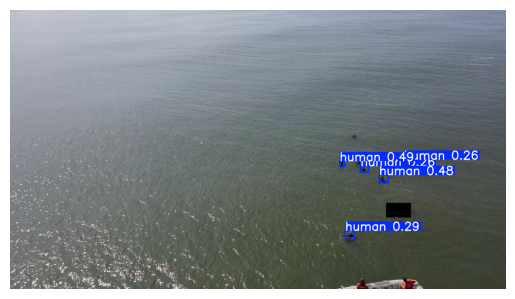

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 655.04it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]


                   all        200       1072      0.684      0.539      0.546      0.205


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.7ms preprocess, 2.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1306f32620>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [8]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)